# Comparison of haplotype frequency to eQTL associations

__Author:__ Bryan Quach  
__Date:__ May 17, 2017

### Estimated Analysis Time: <1 days

## Objective

Create plots of genome-wide haplotype frequencies using the maximum likelihood haplotype for each CC strain. Compare these to the fraction of significantly associated genes for each marker. We hypothesize that markers with a higher number of associations are partially caused by a single or couple haplotypes being dominant in our CC strains.

## The Data

The data we start with are haplotype dosages (diplotype probabilities consolidated into haplotypes) at every genotype marker for every CC strain used in our control analysis. In our QTL analyses, adjacent markers are considered a single marker if they have the same maximum likelihood haplotype (the haplotype with the largest dosage/probability). In these cases, any consolidated markers have their dosages averaged for each haplotype. We will be working with these "merged" haplotype dosages. We also have text files containing chromosome sizes and mappings between marker names and genomic location.

For eQTL data, we have FDR controlled p-values that we filter to only associations with q-value < 0.1. From this we calculate the number of associations with a given marker. FDR correction was performed on results of a cis + trans-eQTL analysis using the R package *qvalue*.

In [1]:
# Load general data
marker.map <- read.delim("data/marker_locations.txt", header=T, stringsAsFactors=F)
rownames(marker.map) <- marker.map$marker
marker.map <- marker.map[-1*which(marker.map$chromosome=="chrM"),] #Remove chrM
chr.sizes <- read.delim("data/mm9_chrom_sizes.txt", header=F, stringsAsFactors=F)
colnames(chr.sizes) <- c("chr","length")

# Convert chromosome lengths and genomic locations to Mb
chr.sizes$length <- chr.sizes$length/1000000
marker.map$position <- marker.map$position/1000000

In [2]:
# Load eQTLs
tmp.lung.eqtl <- readRDS("data//fdr_0.1_lung_trans.rds")
tmp.liver.eqtl <- readRDS("data//fdr_0.1_liver_trans.rds")
tmp.kidney.eqtl <- readRDS("data//fdr_0.1_kidney_trans.rds")
lung.eqtl <- as.numeric(tmp.lung.eqtl$qval)
liver.eqtl <- as.numeric(tmp.liver.eqtl$qval)
kidney.eqtl <- as.numeric(tmp.kidney.eqtl$qval)
names(lung.eqtl) <- as.character(tmp.lung.eqtl$marker)
names(liver.eqtl) <- as.character(tmp.liver.eqtl$marker)
names(kidney.eqtl) <- as.character(tmp.kidney.eqtl$marker)

# Get new names for after division of merged markers into start and end markers
names.lung <- gsub(unlist(strsplit(names(lung.eqtl), split=".", fixed=T)), pattern="\\-", replacement="_")
names.liver <- gsub(unlist(strsplit(names(liver.eqtl), split=".", fixed=T)), pattern="\\-", replacement="_")
names.kidney <- gsub(unlist(strsplit(names(kidney.eqtl), split=".", fixed=T)), pattern="\\-", replacement="_")
lung.eqtl <- rep(lung.eqtl, each=2)
liver.eqtl <- rep(liver.eqtl, each=2)
kidney.eqtl <- rep(kidney.eqtl, each=2)
names(lung.eqtl) <- names.lung
names(liver.eqtl) <- names.liver
names(kidney.eqtl) <- names.kidney

In [3]:
# Tabulate number of significant associations with each marker
count_associations <- function(marker, table){
    hits <- match(x=marker, table=names(table))
    if(is.na(hits)){
        return(0)
    }else if(length(hits)==1){
        return(as.numeric(table[hits]))
    }else{
        stop(paste("Multiple matches found for ", marker, sep=""))
    }
}
lung.table <- table(names(lung.eqtl))
liver.table <- table(names(liver.eqtl))
kidney.table <- table(names(kidney.eqtl))
lung.table <- lung.table[intersect(marker.map$marker, names(lung.table))] # Remove chrM
liver.table <- liver.table[intersect(marker.map$marker, names(liver.table))] # Remove chrM
kidney.table <- kidney.table[intersect(marker.map$marker, names(kidney.table))] # Remove chrM
lung.eqtl.counts <- sapply(marker.map$marker, count_associations, table=lung.table)
liver.eqtl.counts <- sapply(marker.map$marker, count_associations, table=liver.table)
kidney.eqtl.counts <- sapply(marker.map$marker, count_associations, table=kidney.table)
names(lung.eqtl.counts) <- marker.map$marker
names(liver.eqtl.counts) <- marker.map$marker
names(kidney.eqtl.counts) <- marker.map$marker
    
# Get genomic locations for each marker
lung.marker.position <- c(as.numeric(marker.map[names(lung.eqtl.counts), "position"]) +
                     diffinv(chr.sizes$length)[match(marker.map[names(lung.eqtl.counts), "chromosome"], chr.sizes$chr)])
liver.marker.position <- c(as.numeric(marker.map[names(liver.eqtl.counts), "position"]) +
                     diffinv(chr.sizes$length)[match(marker.map[names(liver.eqtl.counts), "chromosome"], chr.sizes$chr)])
kidney.marker.position <- c(as.numeric(marker.map[names(kidney.eqtl.counts), "position"]) +
                     diffinv(chr.sizes$length)[match(marker.map[names(kidney.eqtl.counts), "chromosome"], chr.sizes$chr)])

# Order by genomic location
lung.eqtl.counts <- lung.eqtl.counts[order(lung.marker.position)]
liver.eqtl.counts <- liver.eqtl.counts[order(liver.marker.position)]
kidney.eqtl.counts <- kidney.eqtl.counts[order(kidney.marker.position)]
    
# Divide marker association counts by chromosome
lung.by.chr <- split(x=lung.eqtl.counts, f=marker.map[names(lung.eqtl.counts), "chromosome"][order(lung.marker.position)])
liver.by.chr <- split(x=liver.eqtl.counts, f=marker.map[names(liver.eqtl.counts), "chromosome"][order(liver.marker.position)])
kidney.by.chr <- split(x=kidney.eqtl.counts, f=marker.map[names(kidney.eqtl.counts), "chromosome"][order(kidney.marker.position)])
associations.by.chr <- list(lung=lung.by.chr, liver=liver.by.chr, kidney=kidney.by.chr)

lung.position.by.chr <- split(x=lung.marker.position[order(lung.marker.position)], f=marker.map[names(lung.eqtl.counts), "chromosome"][order(lung.marker.position)])
liver.position.by.chr <- split(x=liver.marker.position[order(liver.marker.position)], f=marker.map[names(liver.eqtl.counts), "chromosome"][order(liver.marker.position)])
kidney.position.by.chr <- split(x=kidney.marker.position[order(kidney.marker.position)], f=marker.map[names(kidney.eqtl.counts), "chromosome"][order(kidney.marker.position)])    
positions.by.chr <- list(lung=lung.position.by.chr, liver=liver.position.by.chr, kidney=kidney.position.by.chr)

## Summarize haplotype dosages as maximum likelihood haplotype frequencies

We summarize our haplotype data by calculating the frequency of a haplotype being the maximum likelihood haplotype across all strains at each marker. The maximum likelihood haplotype is simply the haplotype with the highest dosage value for a given strain at a given marker.

In [4]:
get.ml.haplo <- function(x,dosages){
    marker.haplotypes <- paste(x, LETTERS[1:8], sep="_")
    indices <- match(x=marker.haplotypes, table=colnames(dosages))
    if(length(indices)!=8){stop(paste("Missing haplotypes",length(indices),x))}
    ml.counts <- tabulate(unlist(apply(dosages[,indices], 1, function(x){which(x==max(x))})), nbins=8)
    names(ml.counts) <- marker.haplotypes
    return(ml.counts)
}
dosages <- readRDS("data/merged_haplotype_dosages.rds")
colnames(dosages) <- gsub(colnames(dosages), pattern="\\-", replacement="_") #Standardize marker names
merged.marker.names <- unique(gsub(names(dosages), pattern="_[A-H]$", replacement=""))
dosage.counts <- do.call("cbind", rep(lapply(merged.marker.names, get.ml.haplo, dosages),each=2))
colnames(dosage.counts) <- unlist(strsplit(merged.marker.names, split=".", fixed=T))
rownames(dosage.counts) <- LETTERS[1:8]
dosage.counts <- dosage.counts[,intersect(colnames(dosage.counts), marker.map$marker)] #Remove chrM
dosage.freq <- t(t(dosage.counts)/colSums(dosage.counts))
if(length(which(is.na(dosage.freq), arr.ind=T)[,2])>0){
    dosage.freq <- dosage.freq[,-1*which(is.na(dosage.freq), arr.ind=T)[,2]] #Remove markers with NAs
}

# Retrieve marker positions
marker.position <- c(as.numeric(marker.map[colnames(dosage.freq), "position"]) +
                     diffinv(chr.sizes$length)[match(marker.map[colnames(dosage.freq), "chromosome"], chr.sizes$chr)])
marker.order <- order(marker.position)

# Divide haplotype frequencies by chromosome
haplo.chunks <- apply(dosage.freq[,marker.order], 1, function(x){split(x=x, f=marker.map[colnames(dosage.freq), "chromosome"][marker.order])})
position.chunks <- split(x=marker.position[marker.order], f=marker.map[colnames(dosage.freq), "chromosome"][marker.order])

## Plot haplotype frequencies and signficiant associations across the genome

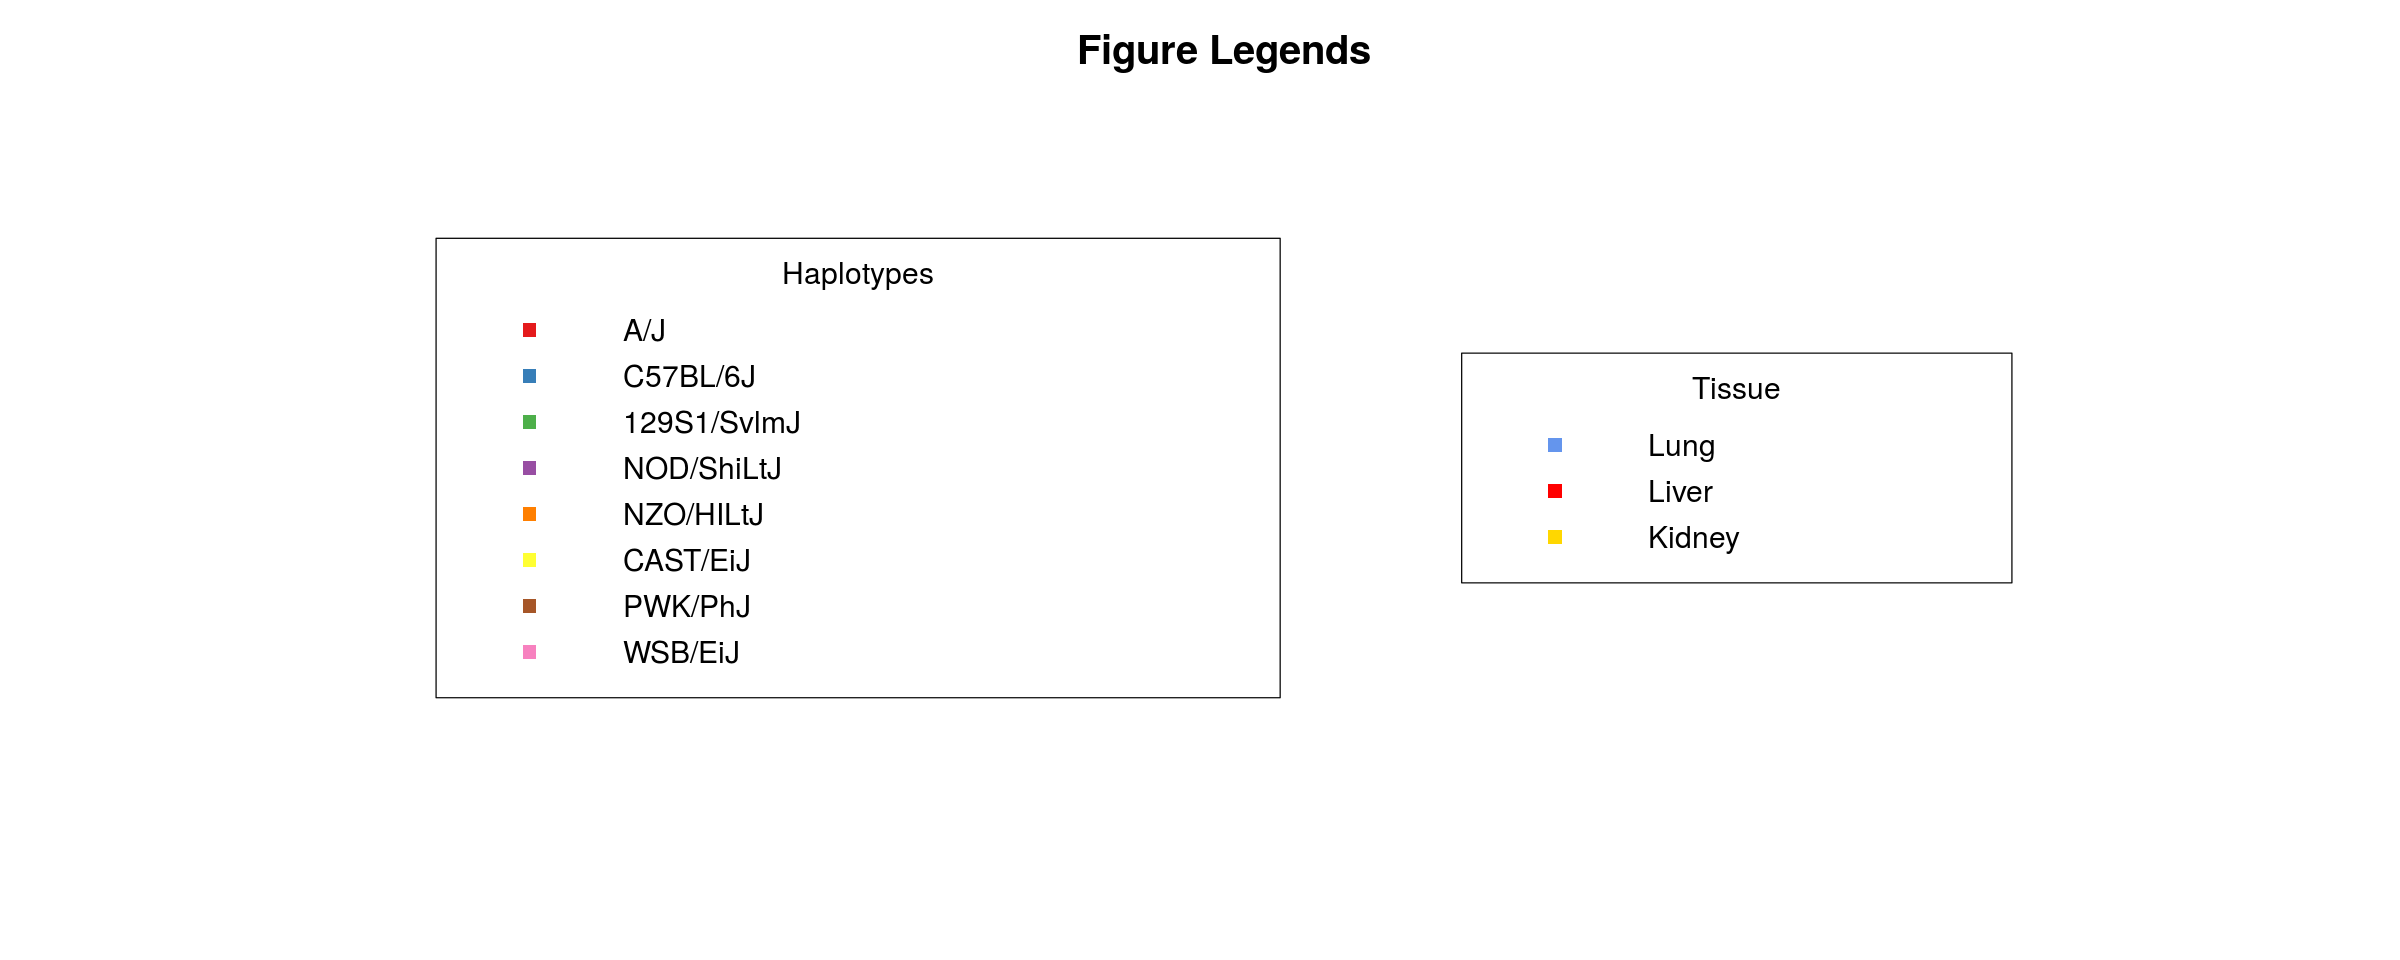

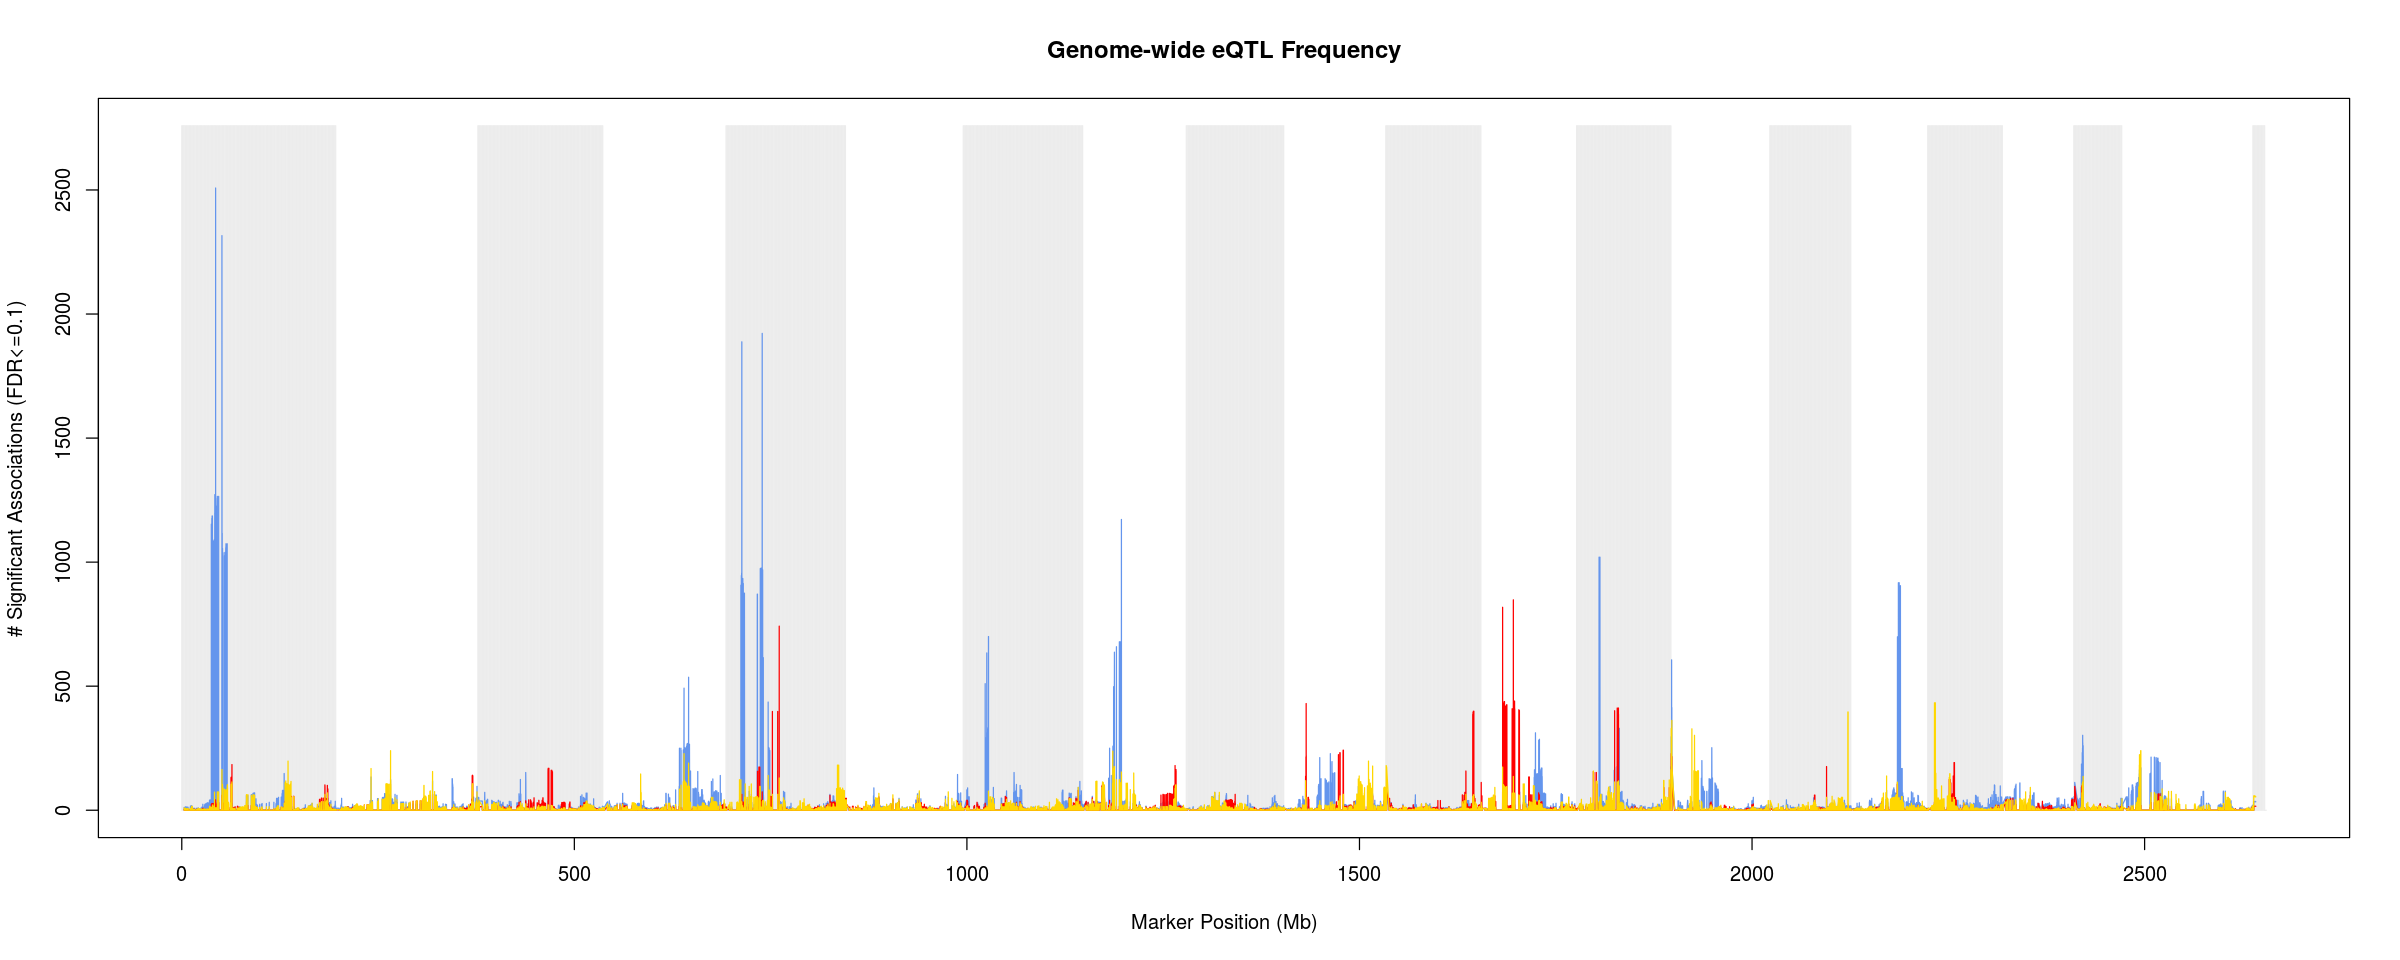

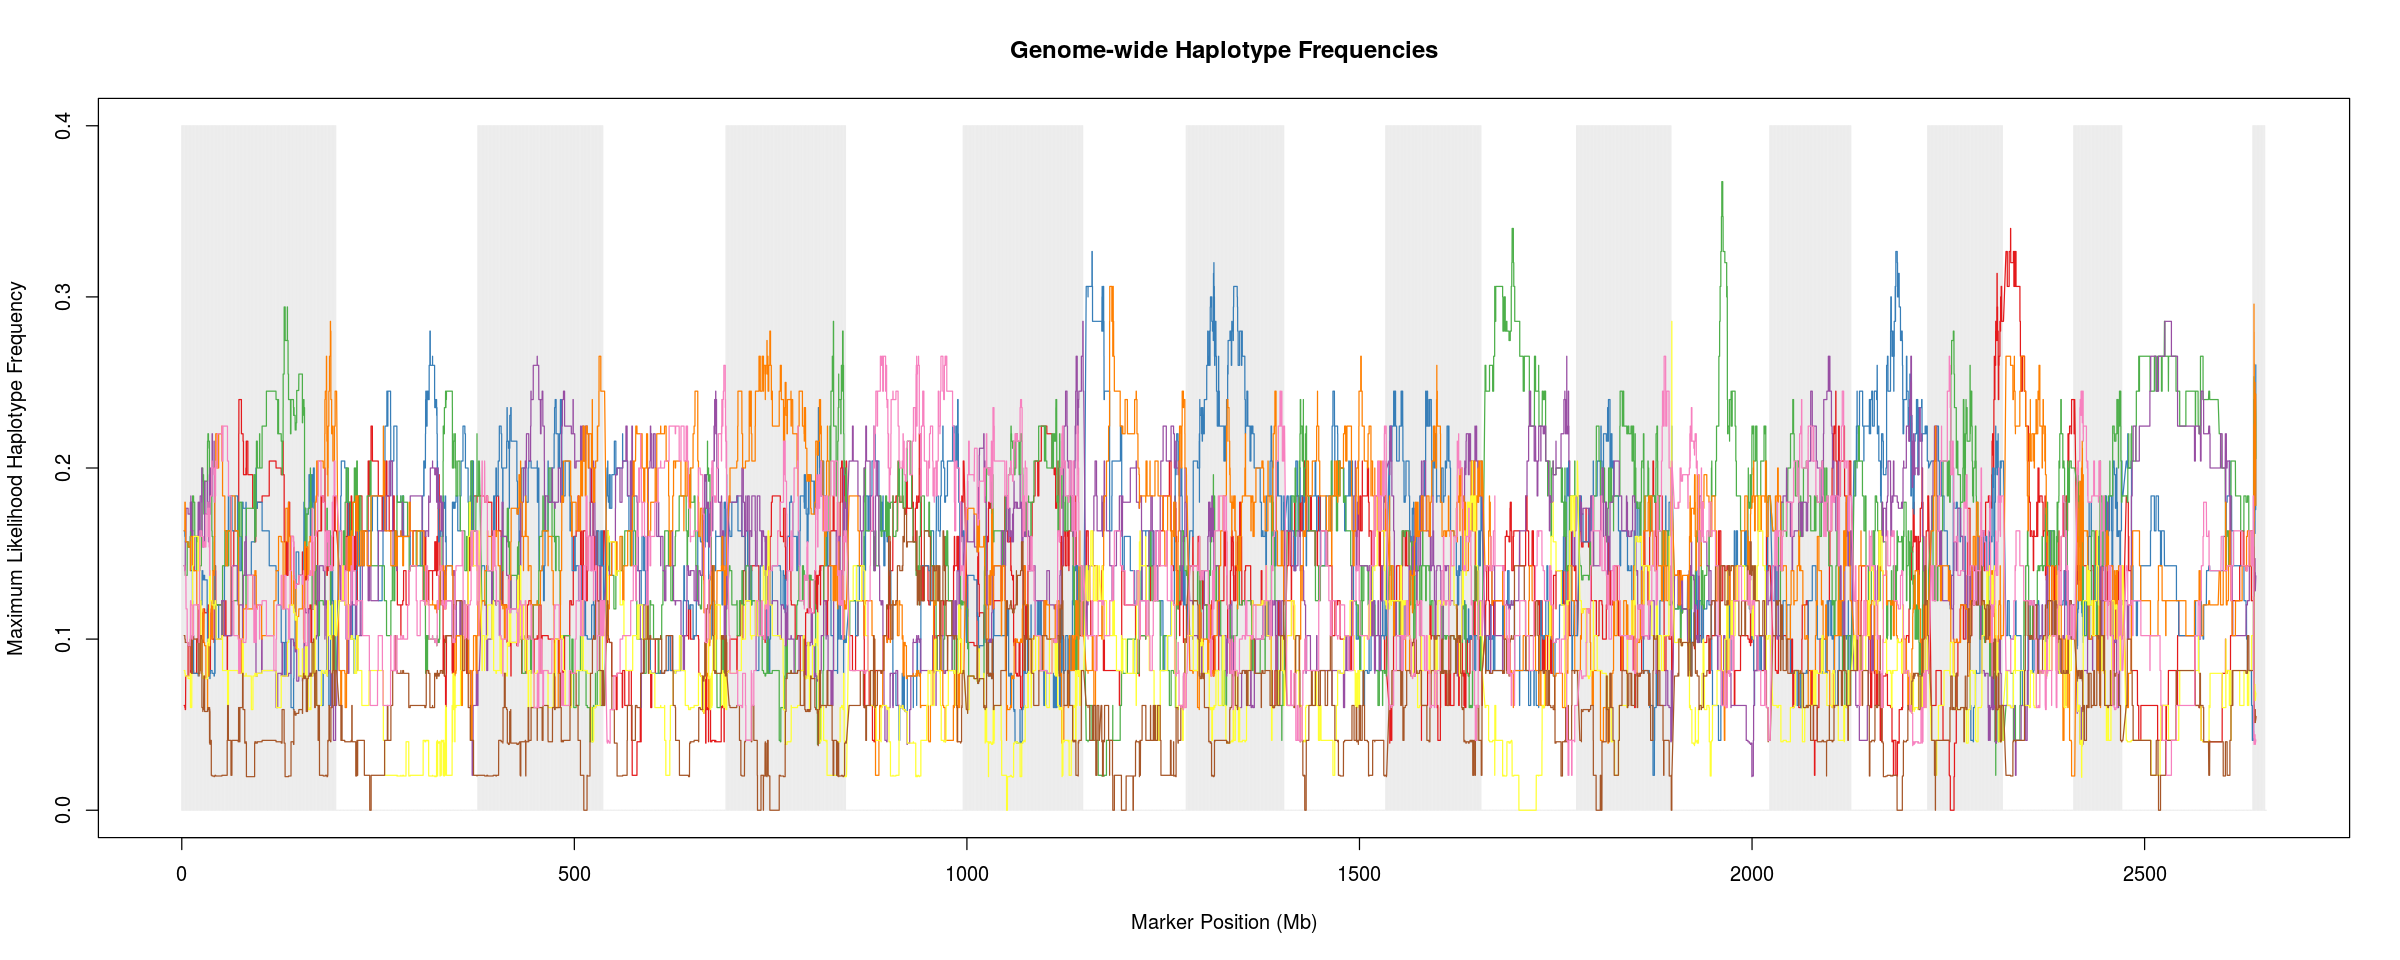

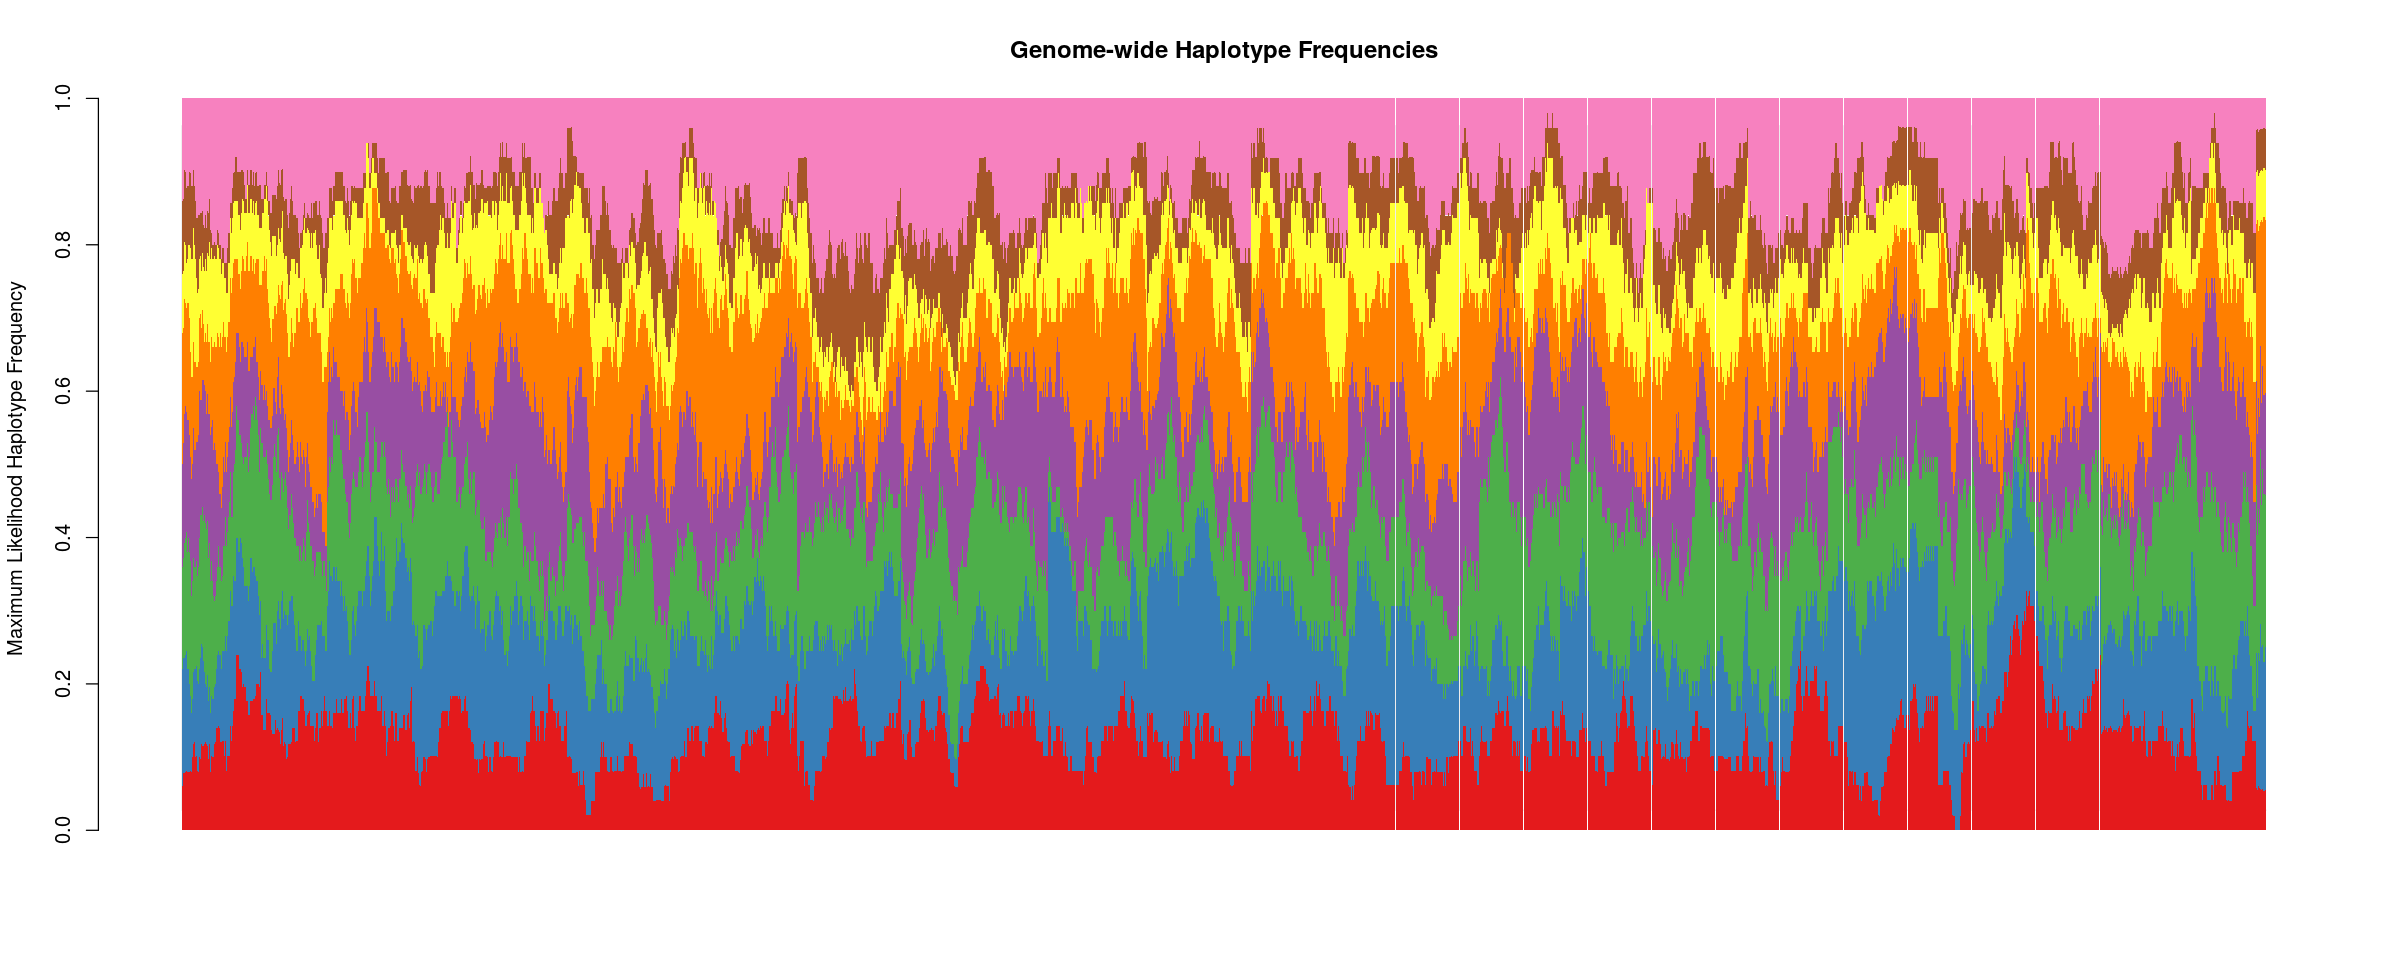

In [5]:
library(RColorBrewer)
options(repr.plot.width=20, repr.plot.height=8)

#Plot Legend
colors<-brewer.pal(8, "Set1")
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", xlab="", ylab="", main="Figure Legends", cex.main=2)
legend("left", pch=15, cex=1.5, col=colors, xpd=T, horiz=F, inset=c(0.15,0), title="Haplotypes",
       legend=c("A/J", "C57BL/6J", "129S1/SvlmJ", "NOD/ShiLtJ", "NZO/HILtJ", "CAST/EiJ", "PWK/PhJ", "WSB/EiJ"))
legend("right", pch=15, cex=1.5, col=c("cornflowerblue","red","gold"), xpd=T, horiz=F, inset=c(0.15,0), title="Tissue",
       legend=c("Lung","Liver","Kidney"))

## Signficant association plot
# Plot alternate shading to distinguish adjacent chromosomes
chrStrips <- seq(0,0,length=sum(chr.sizes$length))
for(i in 2*0:as.integer((nrow(chr.sizes)-1)/2)+1){
    for (j in (diffinv(chr.sizes$length)[i]:diffinv(chr.sizes$length)[i+1])){
        chrStrips[j] <- 1;
    }
}
plot(chrStrips, type='h', col="#ECECEC", xlab='', ylab='', axes=F, ylim=c(0,1))
par(new=TRUE)

# Plot significant association frequencies
plot(x=lung.marker.position[order(lung.marker.position)], y=lung.eqtl.counts,
     ylim=range(c(lung.eqtl.counts, liver.eqtl.counts, kidney.eqtl.counts))*1.1,
     xlim=c(0,sum(chr.sizes$length)), xlab="Marker Position (Mb)", ylab="# Significant Associations (FDR<=0.1)", 
     main="Genome-wide eQTL Frequency", col="cornflowerblue", type="l", lwd=1)
points(x=liver.marker.position[order(liver.marker.position)], y=liver.eqtl.counts, type="l", lwd=1, col="red")
points(x=kidney.marker.position[order(kidney.marker.position)], y=kidney.eqtl.counts, type="l", lwd=1, col="gold")


## Haplotype plot
# Plot alternate shading to distinguish adjacent chromosomes
chrStrips <- seq(0,0,length=sum(chr.sizes$length))
for(i in 2*0:as.integer((nrow(chr.sizes)-1)/2)+1){
    for (j in (diffinv(chr.sizes$length)[i]:diffinv(chr.sizes$length)[i+1])){
        chrStrips[j] <- 1;
    }
}
plot(chrStrips, type='h', col="#ECECEC", xlab='', ylab='', axes=F, ylim=c(0,1))
par(new=TRUE)

# Plot haplotype frequencies
plot(x=marker.position[marker.order], y=dosage.freq["A", marker.order], 
     xlim=c(0,sum(chr.sizes$length)), ylim=c(0,0.4), xlab="Marker Position (Mb)", ylab="Maximum Likelihood Haplotype Frequency", 
     main="Genome-wide Haplotype Frequencies", col=colors[1], type="l", lwd=1)
points(x=marker.position[marker.order], y=dosage.freq["B", marker.order], type="l", lwd=1, col=colors[2])
points(x=marker.position[marker.order], y=dosage.freq["C", marker.order], type="l", lwd=1, col=colors[3])
points(x=marker.position[marker.order], y=dosage.freq["D", marker.order], type="l", lwd=1, col=colors[4])
points(x=marker.position[marker.order], y=dosage.freq["E", marker.order], type="l", lwd=1, col=colors[5])
points(x=marker.position[marker.order], y=dosage.freq["F", marker.order], type="l", lwd=1, col=colors[6])
points(x=marker.position[marker.order], y=dosage.freq["G", marker.order], type="l", lwd=1, col=colors[7])
points(x=marker.position[marker.order], y=dosage.freq["H", marker.order], type="l", lwd=1, col=colors[8])

# Plot haplotype frequencies as a stacked barplots
plot(chrStrips, type='h', col="#ECECEC", xlab='', ylab='', axes=F, ylim=c(0,1))
par(new=TRUE)
barplot(dosage.freq[,marker.order], beside=F, col=colors, border=NA, space=0, 
        names.arg=rep(NA,ncol(dosage.freq)), ylab="Maximum Likelihood Haplotype Frequency", main="Genome-wide Haplotype Frequencies")

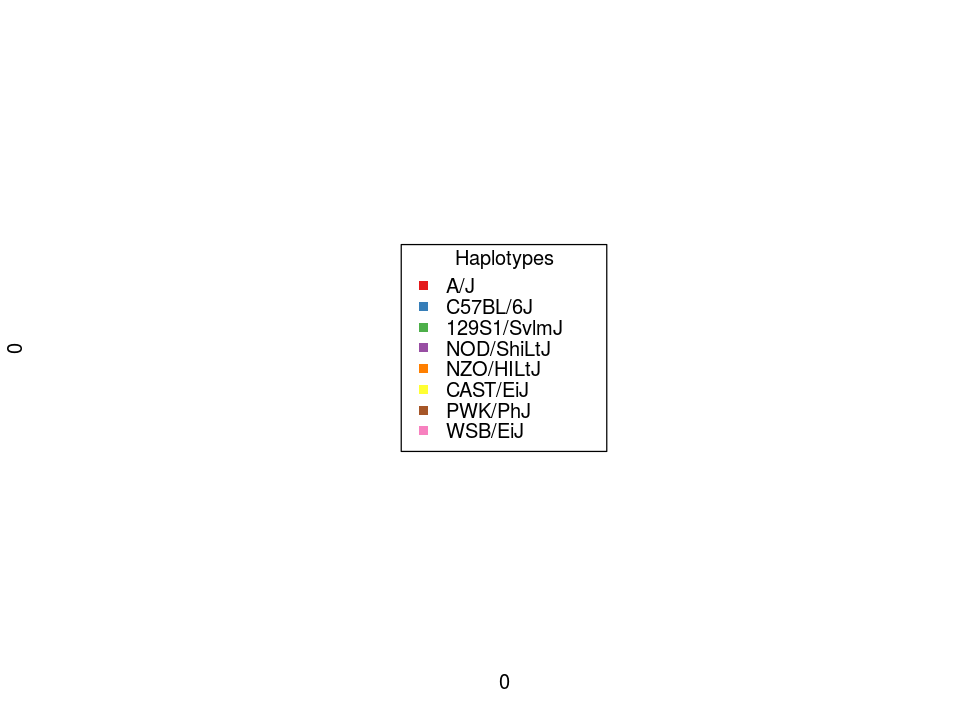

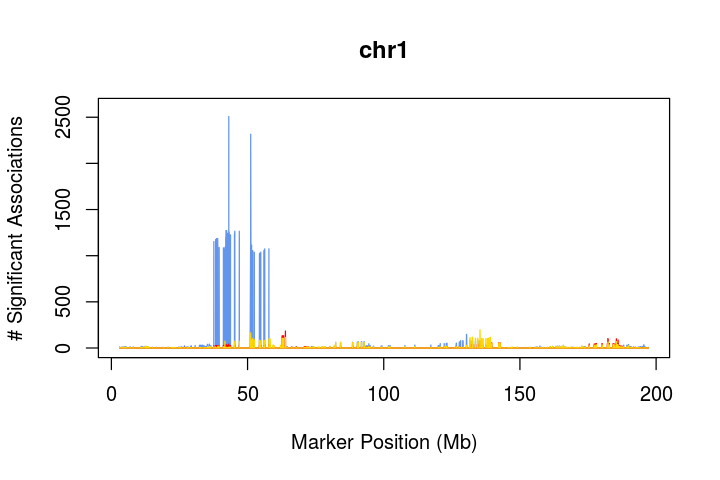

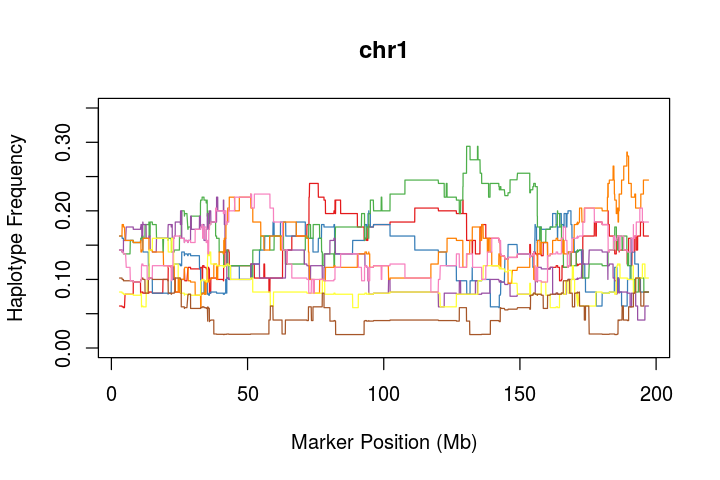

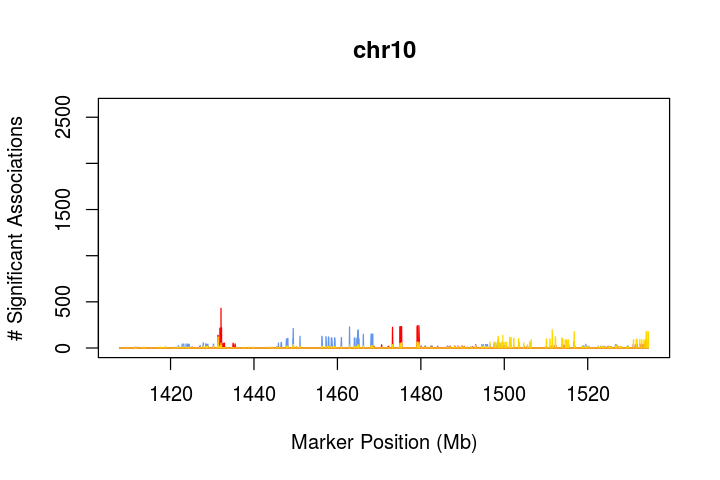

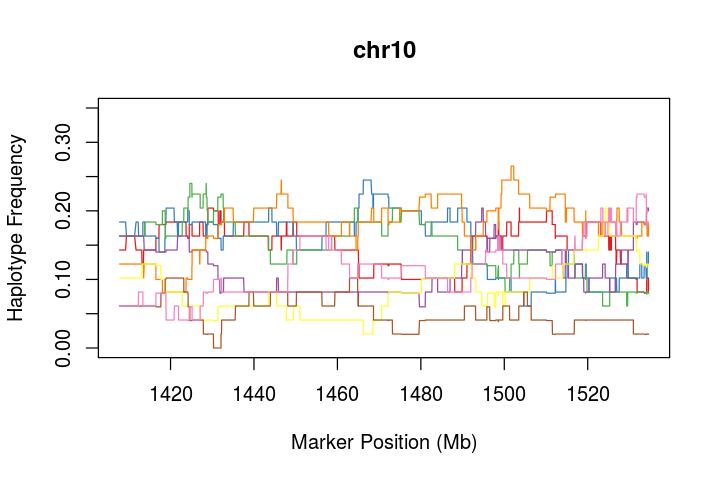

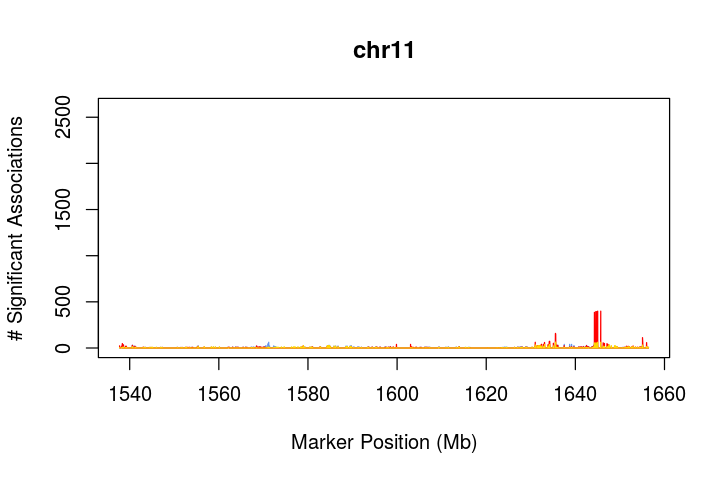

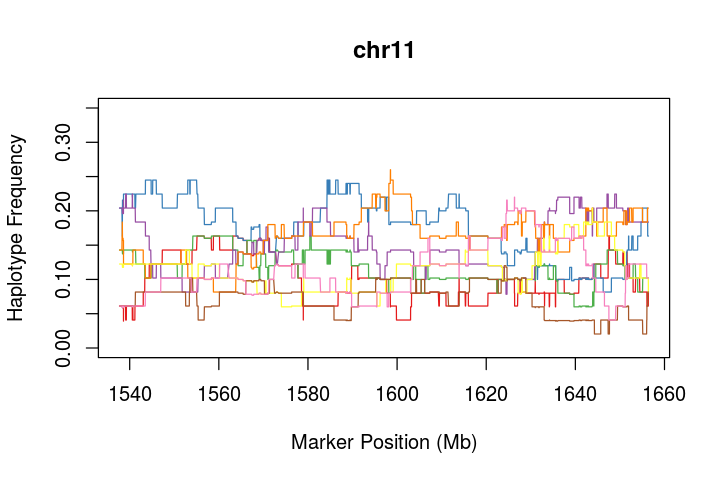

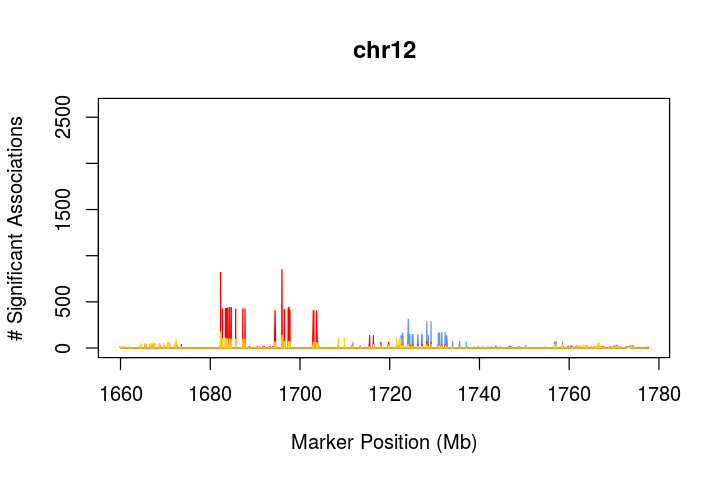

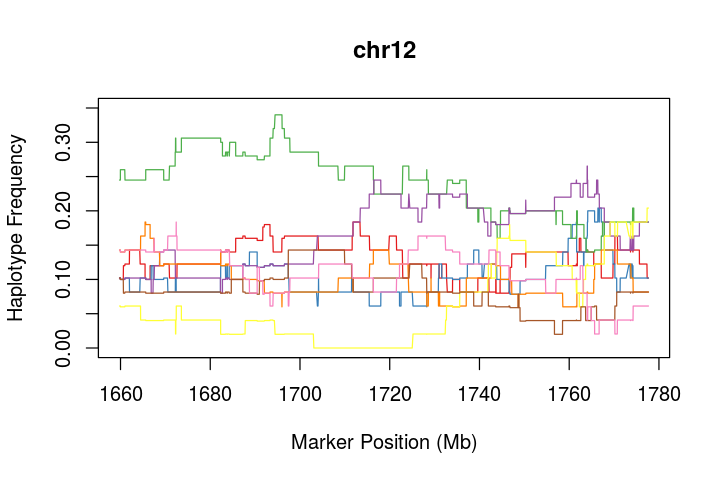

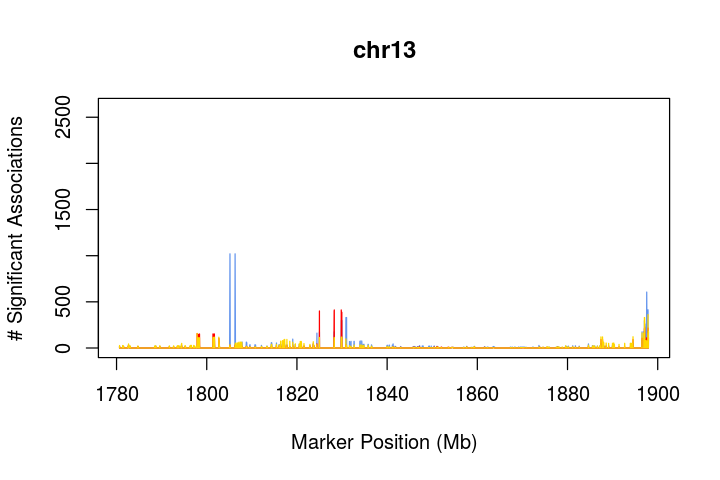

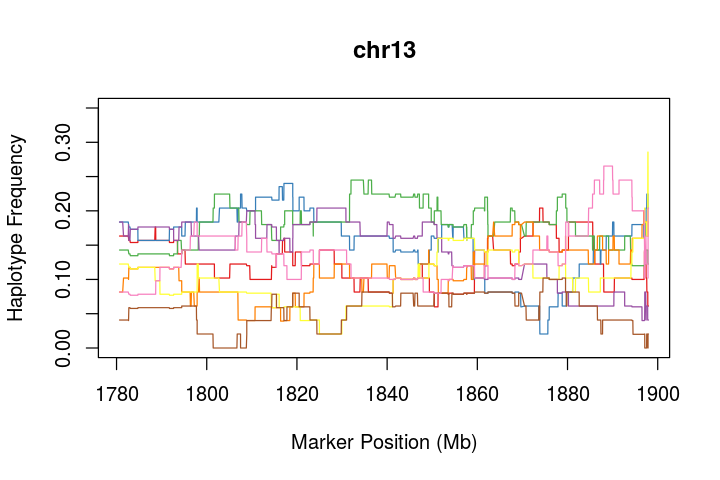

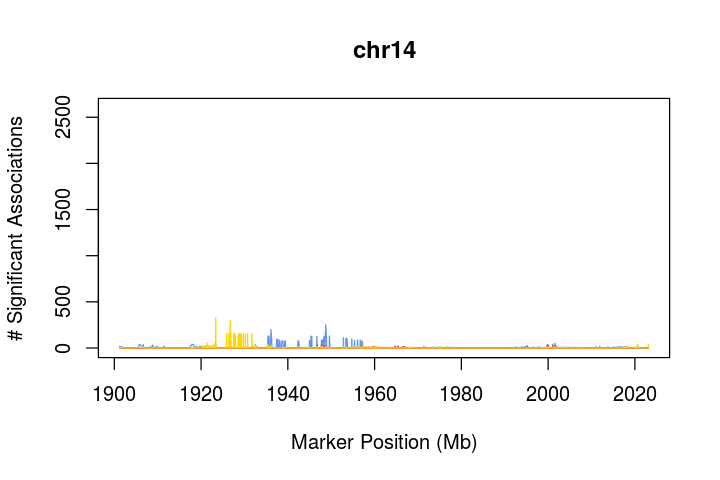

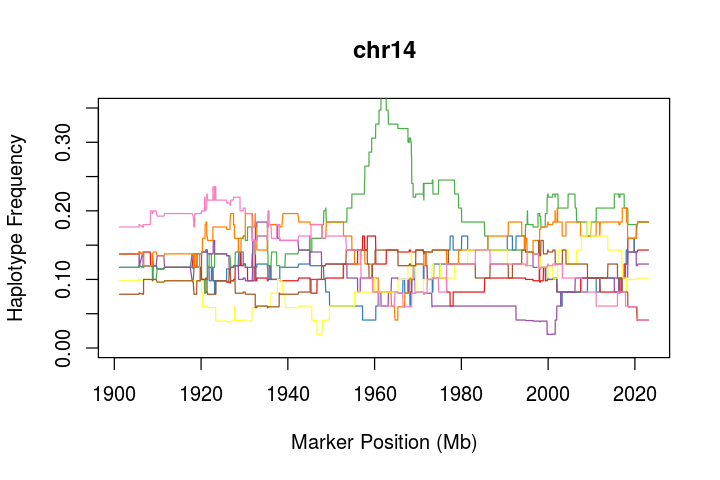

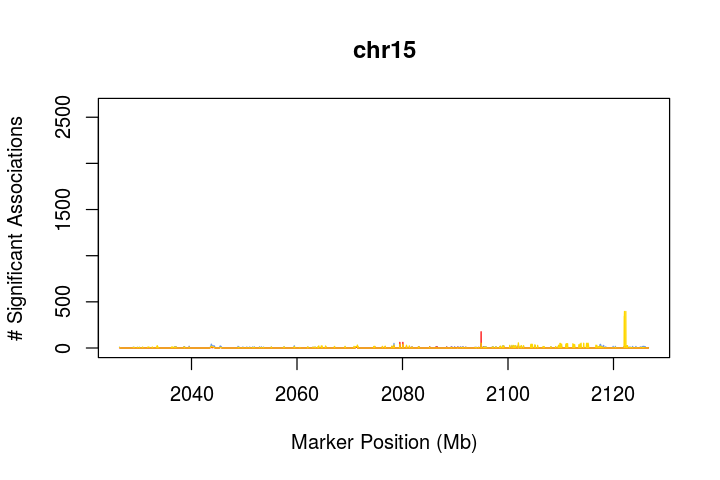

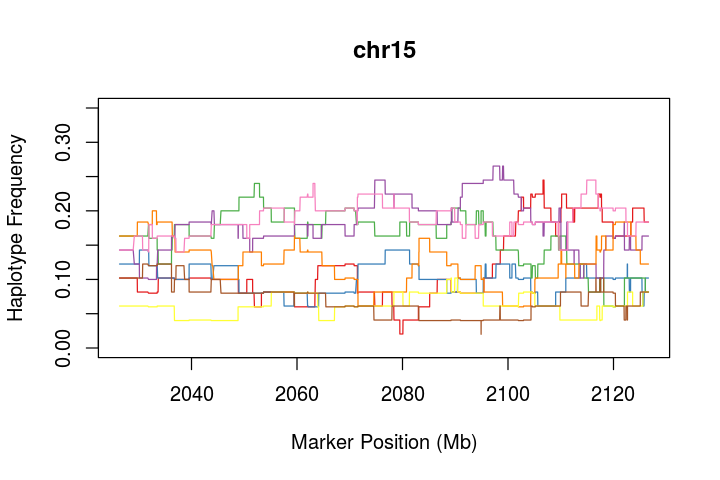

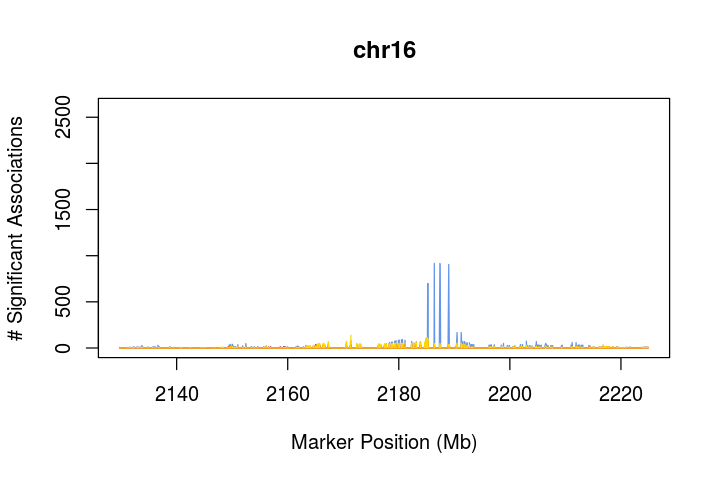

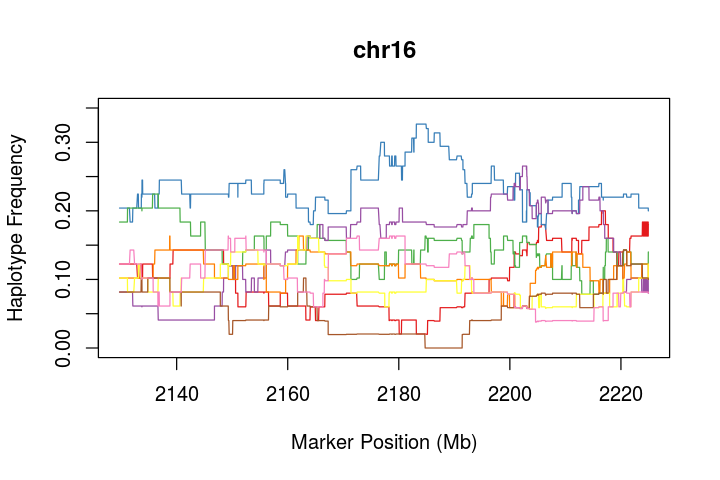

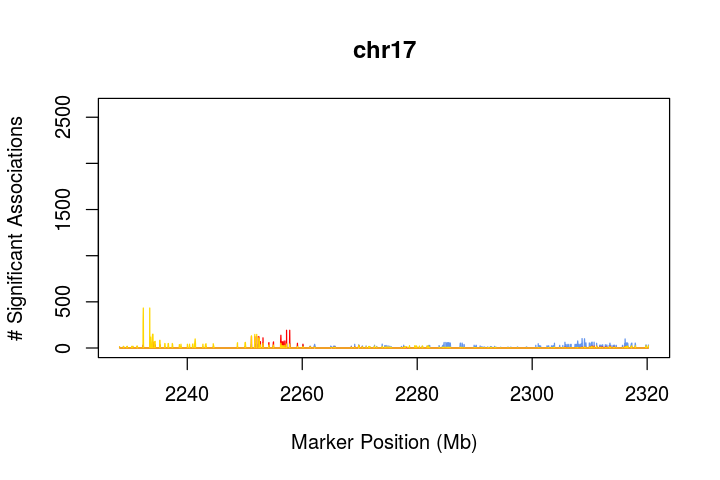

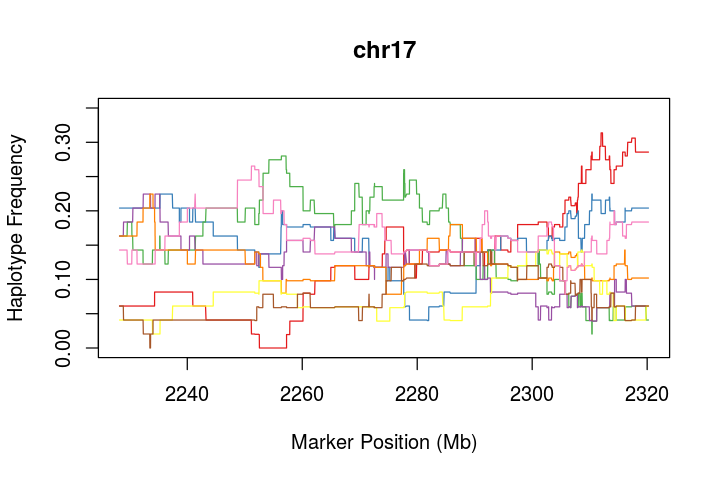

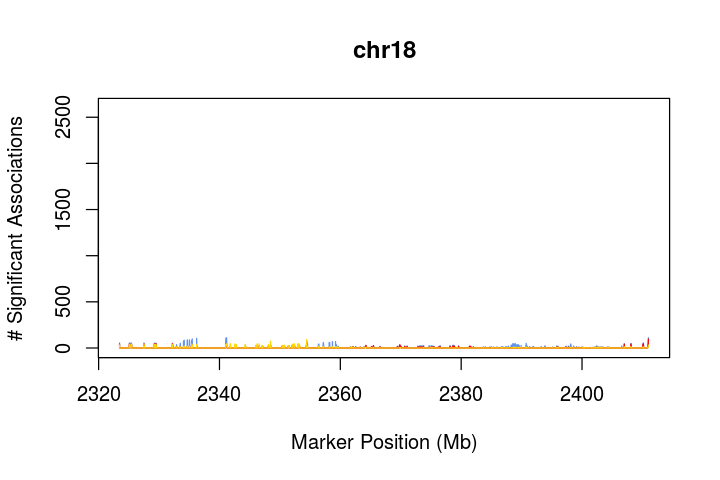

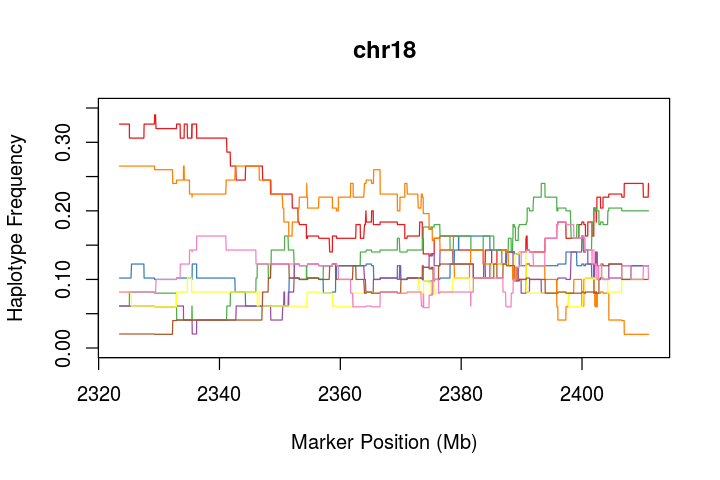

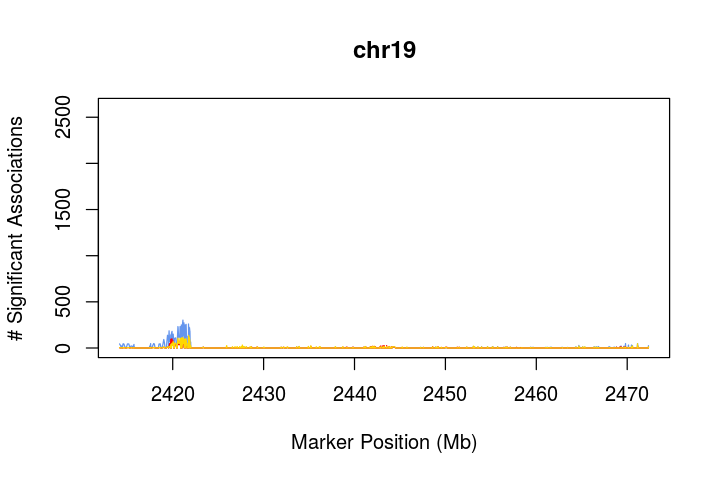

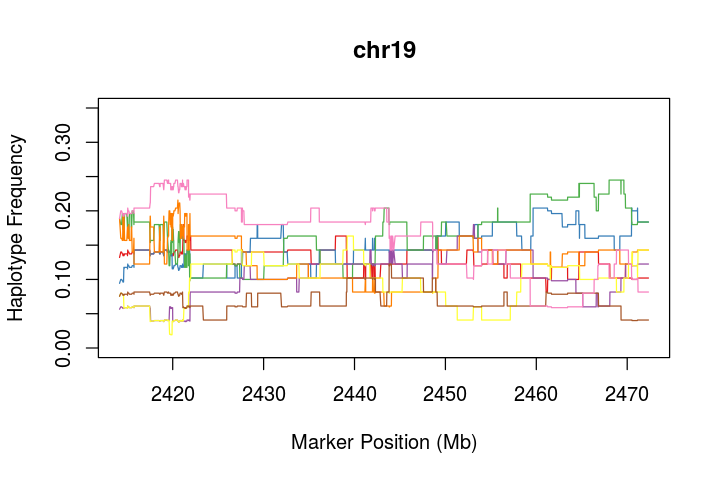

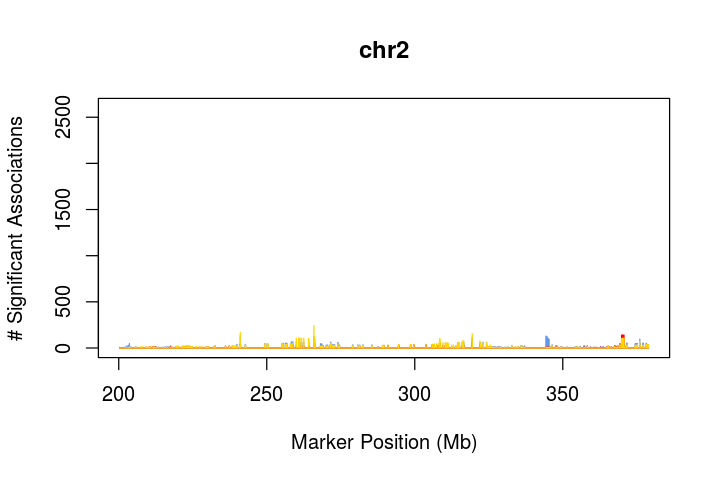

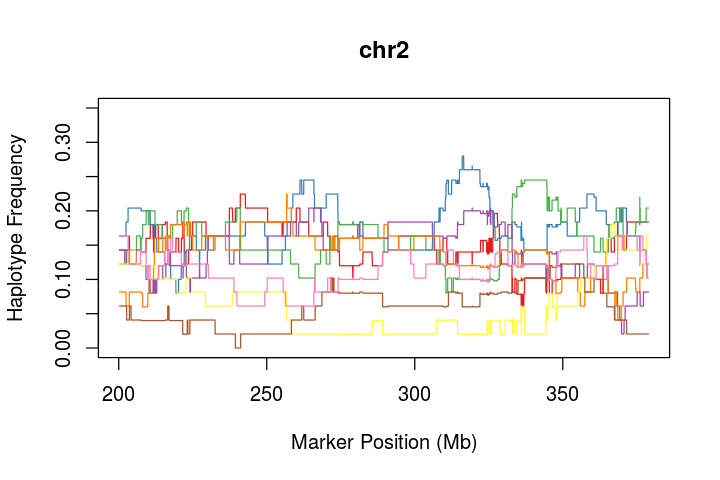

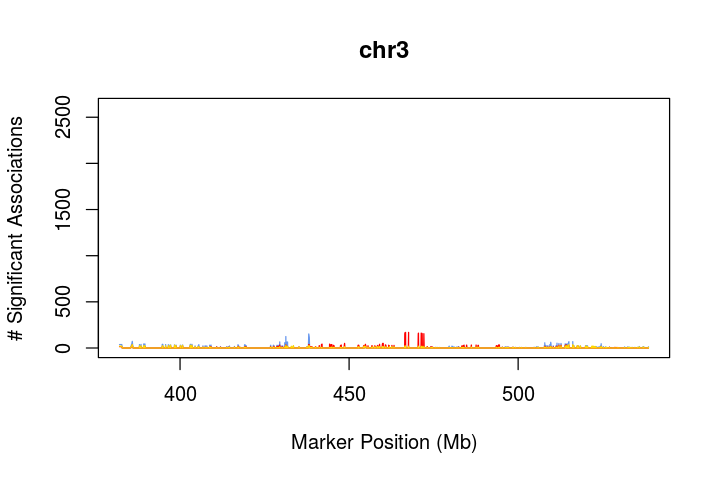

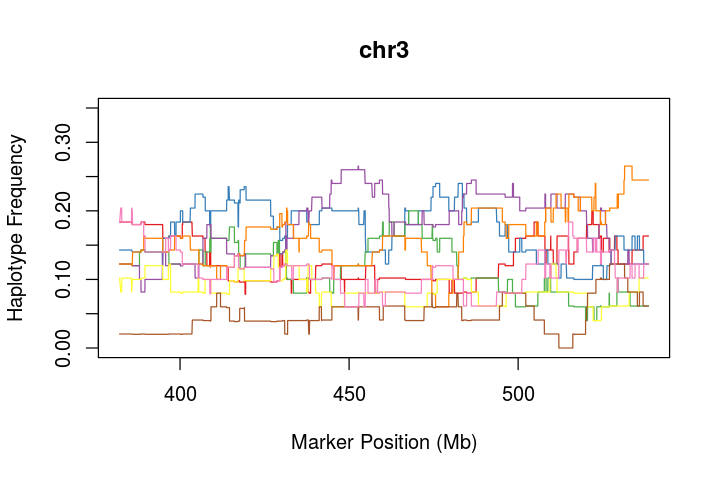

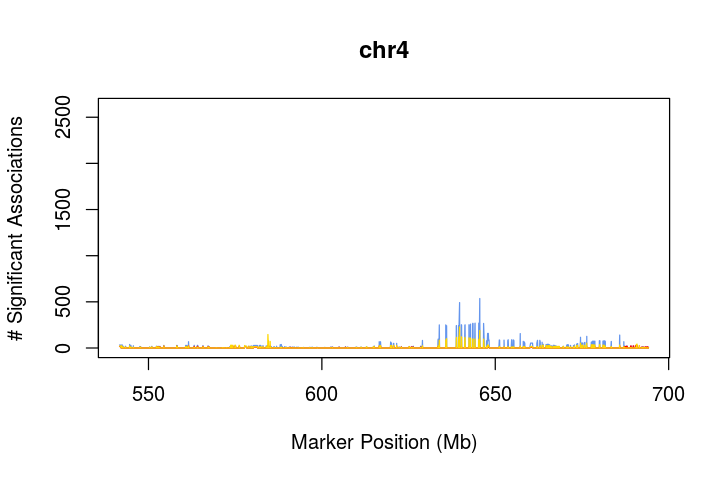

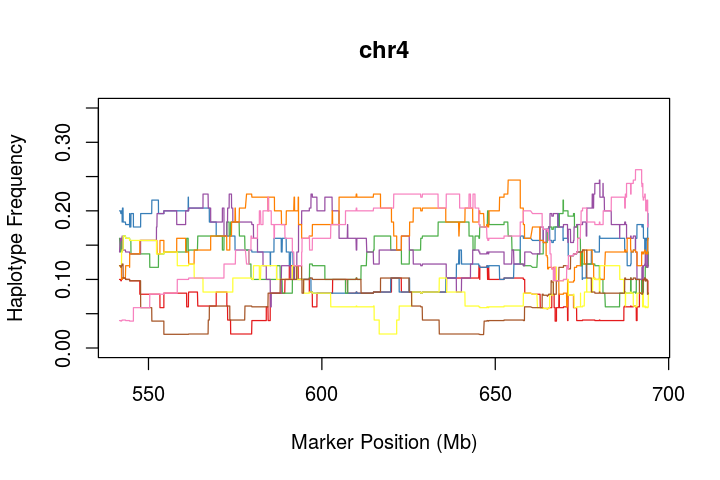

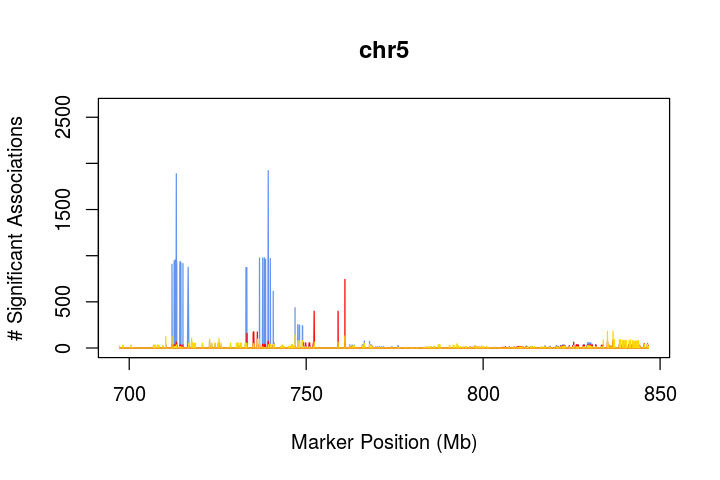

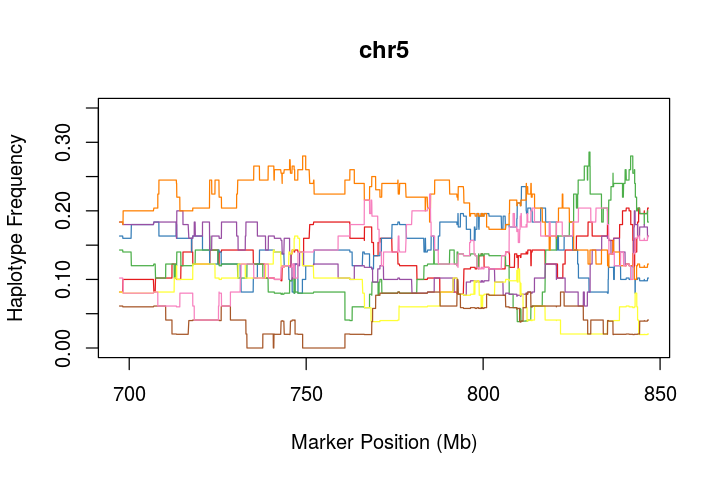

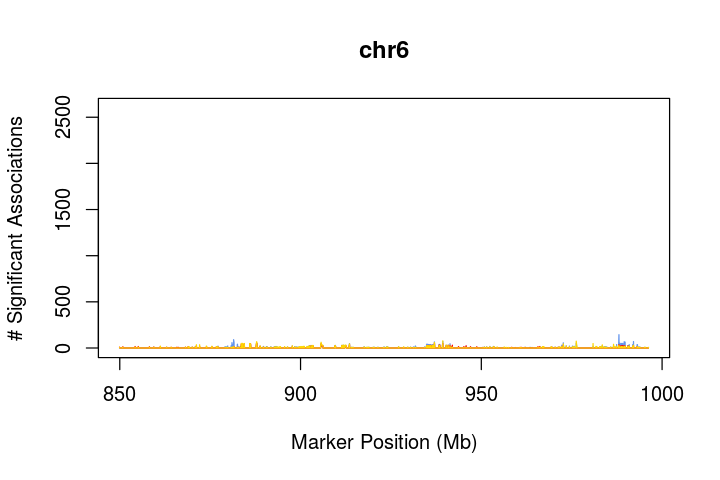

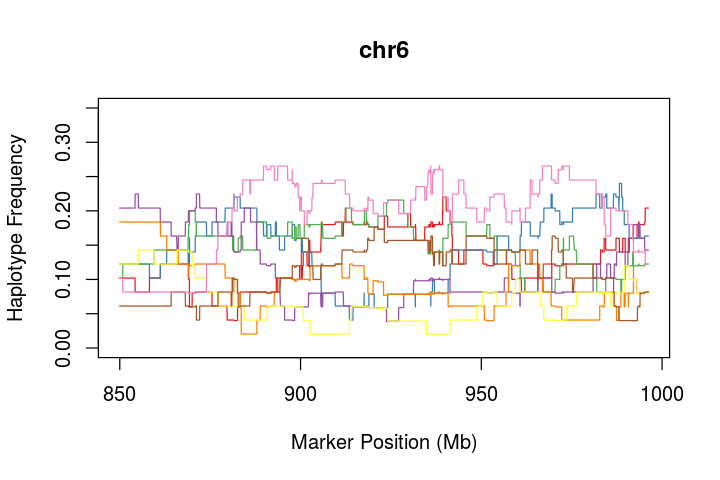

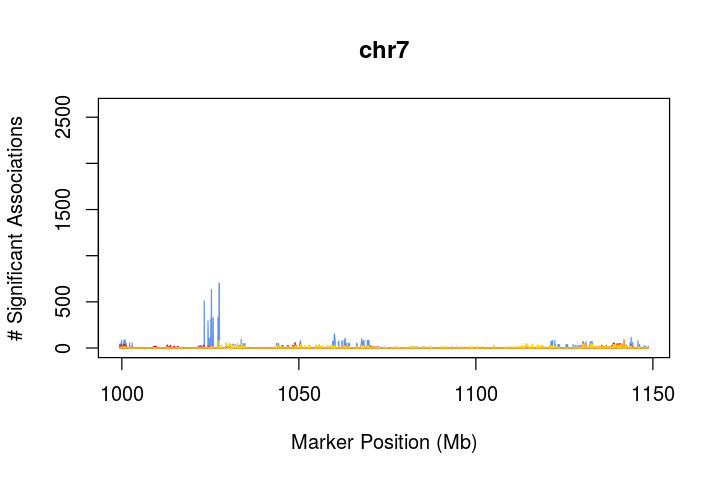

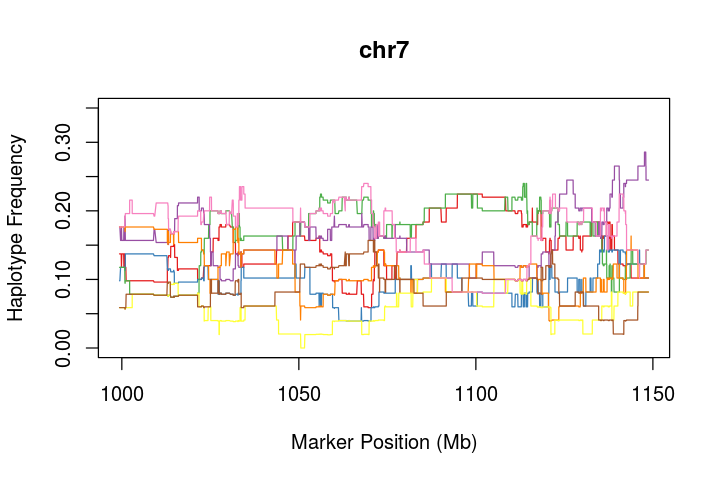

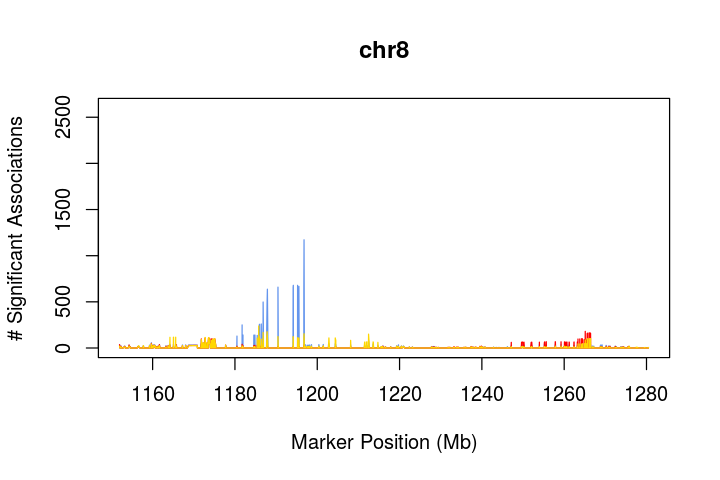

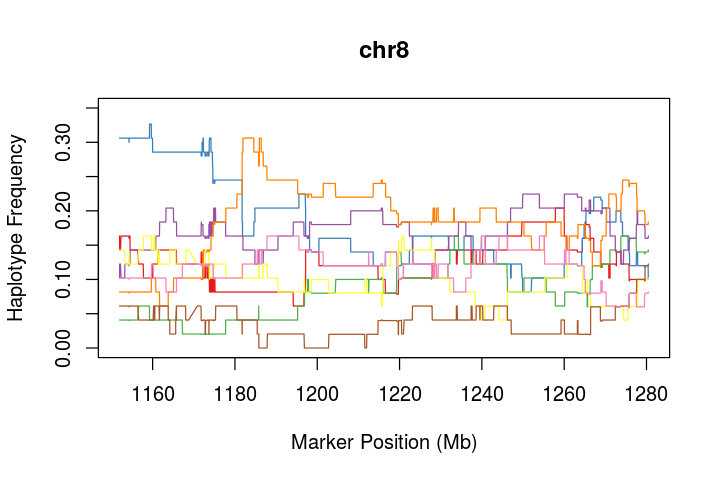

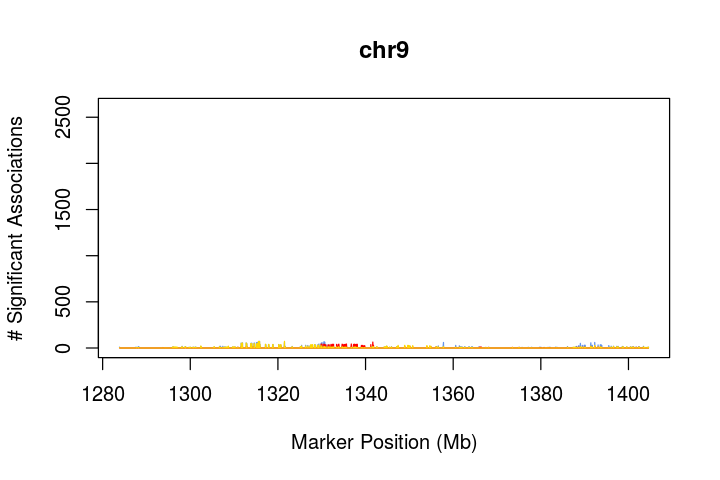

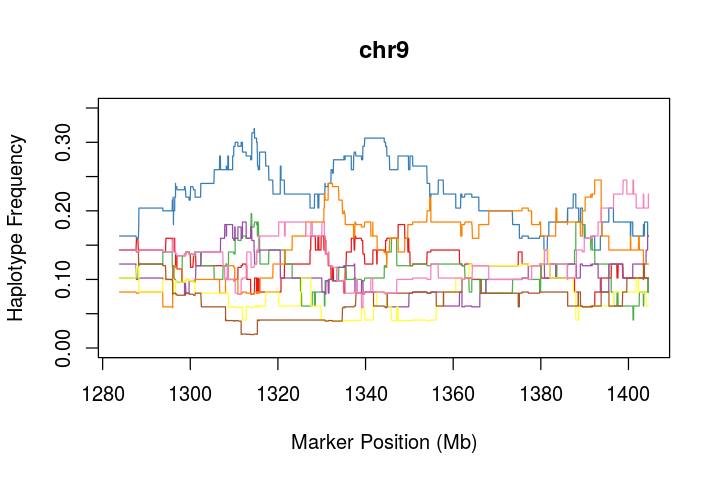

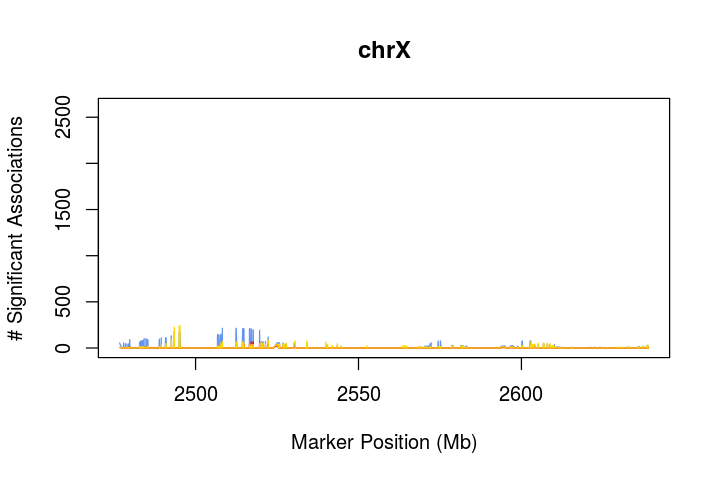

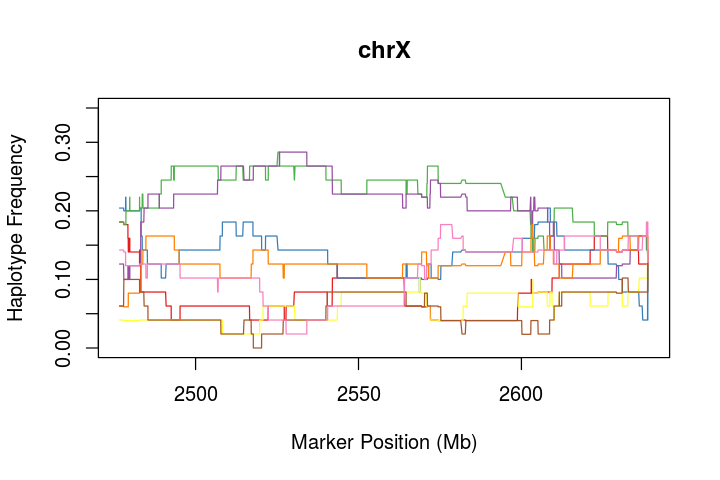

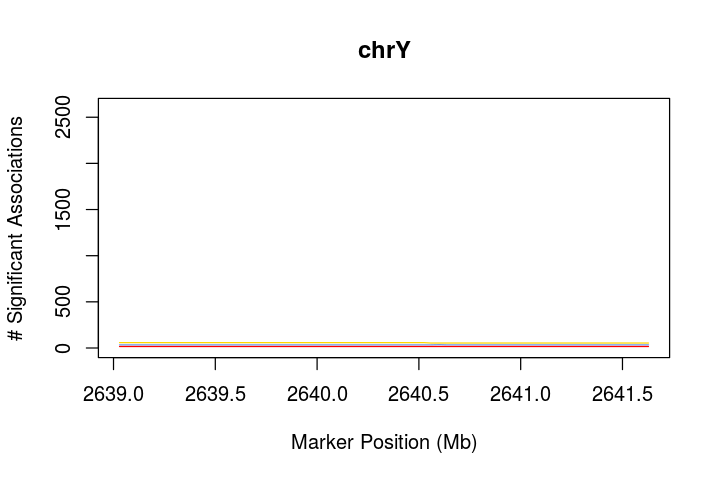

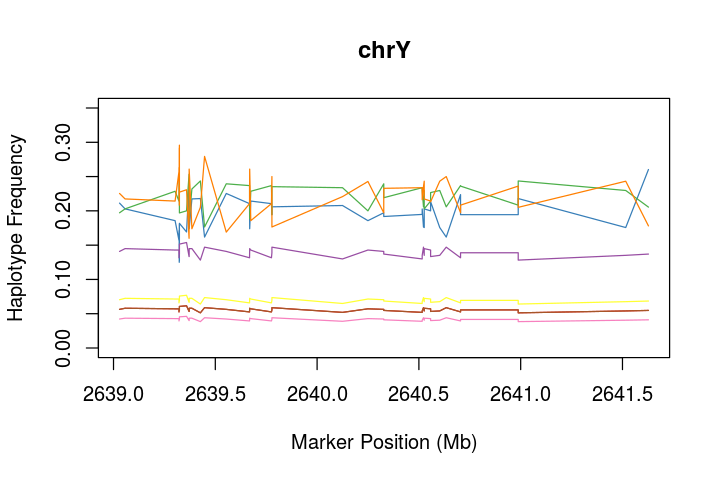

In [6]:
haploplot <- function(freqs, index, name){
    colors<-brewer.pal(8, "Set1")
    plot(x=position.chunks[[index]], y=freqs$A[[index]], ylim=c(0,0.35), 
         xlab="Marker Position (Mb)", ylab="Haplotype Frequency", main=name,
         col=colors[1], type="l", lwd=1)
    points(x=position.chunks[[index]], y=freqs$B[[index]], type="l", lwd=1, col=colors[2])
    points(x=position.chunks[[index]], y=freqs$C[[index]], type="l", lwd=1, col=colors[3])
    points(x=position.chunks[[index]], y=freqs$D[[index]], type="l", lwd=1, col=colors[4])
    points(x=position.chunks[[index]], y=freqs$E[[index]], type="l", lwd=1, col=colors[5])
    points(x=position.chunks[[index]], y=freqs$F[[index]], type="l", lwd=1, col=colors[6])
    points(x=position.chunks[[index]], y=freqs$G[[index]], type="l", lwd=1, col=colors[7])
    points(x=position.chunks[[index]], y=freqs$H[[index]], type="l", lwd=1, col=colors[8])
}
association.plot <- function(association, index, name){
    colors<-c("cornflowerblue", "red", "gold")
    plot(x=positions.by.chr$lung[[index]], y=associations.by.chr$lung[[index]], 
         ylim=c(0,2600),
         xlab="Marker Position (Mb)", ylab="# Significant Associations", main=name,
         col=colors[1], type="l", lwd=1)
    points(x=positions.by.chr$liver[[index]], y=associations.by.chr$liver[[index]], type="l", lwd=1, col=colors[2])
    points(x=positions.by.chr$kidney[[index]], y=associations.by.chr$kidney[[index]], type="l", lwd=1, col=colors[3])
}

# Plot Legend
options(repr.plot.width=8, repr.plot.height=6)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n")
legend("center", pch=15, cex=1, col=colors, xpd=T, horiz=F, inset=c(0,0), title="Haplotypes",
       legend=c("A/J", "C57BL/6J", "129S1/SvlmJ", "NOD/ShiLtJ", "NZO/HILtJ", "CAST/EiJ", "PWK/PhJ", "WSB/EiJ"))

# Plot chromosomes
chr.names <- names(haplo.chunks$A)
options(repr.plot.width=6, repr.plot.height=4)
for(i in 1:length(chr.names)){
    association.plot(associations.by.chr, i, chr.names[i])
    haploplot(haplo.chunks, i, chr.names[i])
}